<a href="https://colab.research.google.com/github/41371115h-dot/114-class-thursday2-4/blob/main/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80%E4%BD%9C%E6%A5%AD%E4%B8%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安裝必要套件
!pip install gspread gspread_dataframe plotly gradio

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd
import datetime
import gradio as gr
import matplotlib.pyplot as plt
import tempfile
import io
import os

# 取得授權並開啟 sheet（換成你的試算表）
creds, _ = default()
gc = gspread.authorize(creds)
SHEET_URL = "https://docs.google.com/spreadsheets/d/1Xbgob0DuSseBy3ktkPaJ17K-tMqK0KfpoX_vMT4YE-U/edit?usp=sharing"
sh = gc.open_by_url(SHEET_URL)
worksheet = sh.sheet1

In [6]:
# ---------- 輔助：normalize 日期 ----------
def normalize_date(val):
    """將各種儲存方式（數字序號、各種字串、datetime）轉成 'YYYY-MM-DD' 或空字串"""
    try:
        if val is None or (isinstance(val, str) and val.strip() == ""):
            return ""
        # 如果已經是 datetime.date 或 datetime.datetime
        if isinstance(val, (datetime.date, datetime.datetime)):
            return val.strftime("%Y-%m-%d")
        # 如果是數字（Excel/Sheets 串列）
        if isinstance(val, (int, float)):
            base = datetime.datetime(1899, 12, 30)
            d = base + datetime.timedelta(days=float(val))
            return d.strftime("%Y-%m-%d")
        s = str(val).strip()
        # 若看起來像整數（日期序號）
        if s.isdigit():
            base = datetime.datetime(1899, 12, 30)
            d = base + datetime.timedelta(days=int(s))
            return d.strftime("%Y-%m-%d")
        # 嘗試 parse 常見格式
        parsed = pd.to_datetime(s, errors='coerce', dayfirst=False)
        if pd.isna(parsed):
            s2 = s.replace('/', '-').replace('.', '-')
            parsed2 = pd.to_datetime(s2, errors='coerce', dayfirst=False)
            if pd.isna(parsed2):
                return ""
            else:
                return parsed2.strftime("%Y-%m-%d")
        else:
            return parsed.strftime("%Y-%m-%d")
    except Exception:
        return ""

# ---------- 讀取並正規化 sheet ----------
def load_records():
    """
    讀取 worksheet，若第一列不是欄位名稱則自動補標題。
    回傳 (df, err_msg_or_None)
    """
    try:
        raw = worksheet.get_all_values()
    except Exception as e:
        return pd.DataFrame(), f"⚠️ 讀取 Google Sheet 失敗：{e}"

    if not raw:
        return pd.DataFrame(columns=["日期","餐別","食物","熱量"]), None

    headers = raw[0]
    # 如果第一列沒有關鍵字（判斷是否為標題），就把它視為資料並補上標題
    if not any(h in headers for h in ["日期","餐別","食物","熱量"]):
        headers = ["日期","餐別","食物","熱量"]
        data_rows = raw
    else:
        data_rows = raw[1:]

    # 建 DataFrame（若欄位數不一致，用最短或補空）
    df = pd.DataFrame(data_rows, columns=headers)

    # 確保必要欄位存在
    for c in ["日期","餐別","食物","熱量"]:
        if c not in df.columns:
            df[c] = ""

    # 轉換日期與熱量
    df["日期"] = df["日期"].apply(normalize_date)
    df["熱量"] = pd.to_numeric(df["熱量"], errors="coerce")  # 轉數字，無法轉為 NaN

    # 把欄位順序固定好，避免匯出時亂序
    df = df[["日期","餐別","食物","熱量"]]

    return df, None

# ---------- 新增紀錄 ----------
def add_record(date, meal, food, calories):
    try:
        worksheet.append_row([date, meal, food, calories])
        return "✅ 新增成功！"
    except Exception as e:
        return f"⚠️ 新增失敗：{e}"

# ---------- 刪除紀錄（用列號） ----------
def delete_record(row_number):
    try:
        # 使用者輸入從1開始，sheet 的第一列有可能是標題
        # 這裡直接刪除第 row_number+0 （假設我們顯示給使用者的是資料的 index，若需不同可調整）
        worksheet.delete_rows(int(row_number))
        return f"🗑️ 刪除成功（刪除列 {int(row_number)}）"
    except Exception as e:
        return f"⚠️ 刪除失敗：{e}"

# ---------- 查詢紀錄（安全處理日期範圍） ----------
def query_records(start_date, end_date, meal_type):
    df, err = load_records()
    if err:
        return None, err
    if df.empty:
        return None, "目前沒有任何紀錄"

    # 處理邊界
    sd = start_date if start_date else "0000-01-01"
    ed = end_date if end_date else "9999-12-31"

    # 驗證格式
    def valid_ymd(s):
        try:
            pd.to_datetime(s, format="%Y-%m-%d")
            return True
        except:
            return False

    if sd != "0000-01-01" and not valid_ymd(sd):
        return None, "⚠️ 起始日期格式錯誤，請使用 YYYY-MM-DD 或留空"
    if ed != "9999-12-31" and not valid_ymd(ed):
        return None, "⚠️ 結束日期格式錯誤，請使用 YYYY-MM-DD 或留空"

    df_filtered = df[(df["日期"] >= sd) & (df["日期"] <= ed)]
    if meal_type and meal_type != "全部":
        df_filtered = df_filtered[df_filtered["餐別"] == meal_type]

    if df_filtered.empty:
        return None, "查無資料"

    # 當前 DataFrame 所有熱量如為 NaN 則保持 NaN（顯示上用空字串）
    df_display = df_filtered.copy()
    df_display["熱量"] = df_display["熱量"].fillna("")

    return df_display.reset_index(drop=True), f"✅ 找到 {len(df_display)} 筆資料"

# ---------- 匯出 CSV/JSON（修正亂碼問題） ----------
def export_records(filetype):
    df, err = load_records()
    if err:
        return None, err
    if df.empty:
        return None, "沒有資料可匯出"

    # 檔名
    today = datetime.date.today().isoformat()
    if filetype == "CSV":
        tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")
        # 使用 utf-8-sig，讓 Excel 在 Windows 開啟不會亂碼
        df.to_csv(tmp.name, index=False, encoding="utf-8-sig")
        return tmp.name, f"✅ 匯出 CSV：{os.path.basename(tmp.name)}"
    else:
        tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".json")
        df.to_json(tmp.name, orient="records", force_ascii=False, indent=2)
        return tmp.name, f"✅ 匯出 JSON：{os.path.basename(tmp.name)}"

# ---------- 產生圖表並存檔（折線圖 + 圓餅圖） ----------
def generate_charts_and_save():
    df, err = load_records()
    if err:
        return None, None, err
    if df.empty:
        return None, None, "⚠️ 沒有資料可視覺化"

    # 只取有日期且熱量為數值的資料來做圖
    df_plot = df.copy()
    df_plot = df_plot[df_plot["日期"] != ""].copy()
    if df_plot.empty:
        return None, None, "⚠️ 沒有可供視覺化的日期資料"

    # 1) 每日總熱量折線圖
    daily = df_plot.groupby("日期", as_index=False)["熱量"].sum().sort_values("日期")
    if daily.empty or daily["熱量"].isna().all():
        return None, None, "⚠️ 沒有可視覺化的熱量數據"

    # 折線
    plt.figure(figsize=(8,4))
    plt.plot(daily["日期"], daily["熱量"], marker='o', linestyle='-')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("date")
    plt.ylabel("kcal")
    plt.title("all kcal")
    plt.tight_layout()
    tmp_line = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    plt.savefig(tmp_line.name, dpi=200)
    plt.close()

    # 2) 餐別圓餅圖（以有數值的熱量）
    df_pie = df_plot.dropna(subset=["熱量"]).copy()
    if df_pie.empty:
        tmp_pie_path = None
    else:
        pie = df_pie.groupby("餐別", as_index=False)["熱量"].sum()
        plt.figure(figsize=(6,6))
        plt.pie(pie["熱量"], labels=pie["餐別"], autopct="%1.1f%%", startangle=90)
        plt.title("Calorie distribution by meal")
        plt.tight_layout()
        tmp_pie = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
        plt.savefig(tmp_pie.name, dpi=200)
        plt.close()
        tmp_pie_path = tmp_pie.name

    return tmp_line.name, tmp_pie_path, "✅ 圖表生成完成"

In [7]:
# ========== Gradio 介面 ==========
with gr.Blocks() as app:
    gr.Markdown("# 🍱 飲食紀錄助理（Colab 版）")

    with gr.Tab("📥 新增紀錄"):
        date_in = gr.Textbox(label="日期 (YYYY-MM-DD)", value=str(datetime.date.today()))
        meal_in = gr.Dropdown(["breakfast","lunch","dinner","snack"], label="餐別")
        food_in = gr.Textbox(label="食物")
        cal_in = gr.Number(label="熱量 (kcal)")
        add_btn = gr.Button("✅ 新增")
        add_out = gr.Textbox(label="狀態")
        add_btn.click(add_record, inputs=[date_in, meal_in, food_in, cal_in], outputs=add_out)

    with gr.Tab("🔍 查詢紀錄"):
        s_in = gr.Textbox(label="起始日期 (YYYY-MM-DD)")
        e_in = gr.Textbox(label="結束日期 (YYYY-MM-DD)")
        meal_filter = gr.Dropdown(["all","breakfast","lunch","dinner","snack"], label="餐別")
        q_btn = gr.Button("🔎 查詢")
        q_table = gr.DataFrame()
        q_msg = gr.Textbox(label="訊息")
        def run_q(s,e,m):
            df, msg = query_records(s, e, m)
            return (df if df is not None else pd.DataFrame()), msg
        q_btn.click(run_q, inputs=[s_in, e_in, meal_filter], outputs=[q_table, q_msg])

    with gr.Tab("🗑️ 刪除紀錄"):
        del_row = gr.Number(label="要刪除的列號（從 1 開始）")
        del_btn = gr.Button("刪除")
        del_msg = gr.Textbox(label="結果")
        del_btn.click(delete_record, inputs=del_row, outputs=del_msg)

    with gr.Tab("📤 匯出紀錄"):
        filetype = gr.Dropdown(["CSV","JSON"], label="格式")
        exp_btn = gr.Button("匯出")
        file_out = gr.File(label="下載檔案")
        exp_msg = gr.Textbox(label="訊息")
        def do_export(ft):
            path, msg = export_records(ft)
            return path, msg
        exp_btn.click(do_export, inputs=filetype, outputs=[file_out, exp_msg])

    with gr.Tab("📊 視覺化統計"):
        chart_btn = gr.Button("📈 生成圖表")
        chart_line = gr.Image(label="每日總熱量")
        chart_pie = gr.Image(label="餐別熱量比例")
        chart_msg = gr.Textbox(label="訊息")
        chart_file_line = gr.File(label="下載折線圖")
        chart_file_pie = gr.File(label="下載圓餅圖")
        def make_charts():
            line_path, pie_path, msg = generate_charts_and_save()
            return (line_path if line_path else None,
                    pie_path if pie_path else None,
                    msg,
                    line_path if line_path else None,
                    pie_path if pie_path else None)
        chart_btn.click(make_charts, outputs=[chart_line, chart_pie, chart_msg, chart_file_line, chart_file_pie])

In [5]:
app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfd250a3d1840c0a18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **視覺畫圖表**

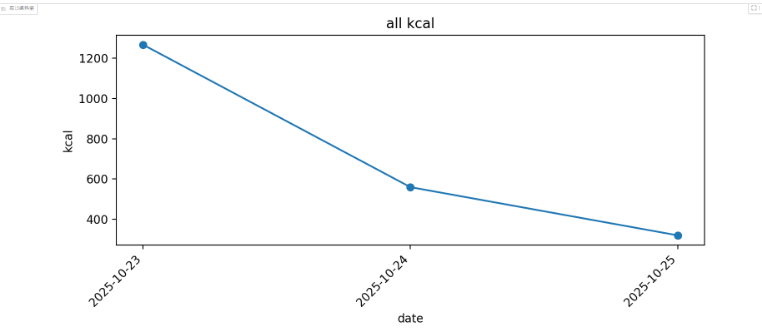

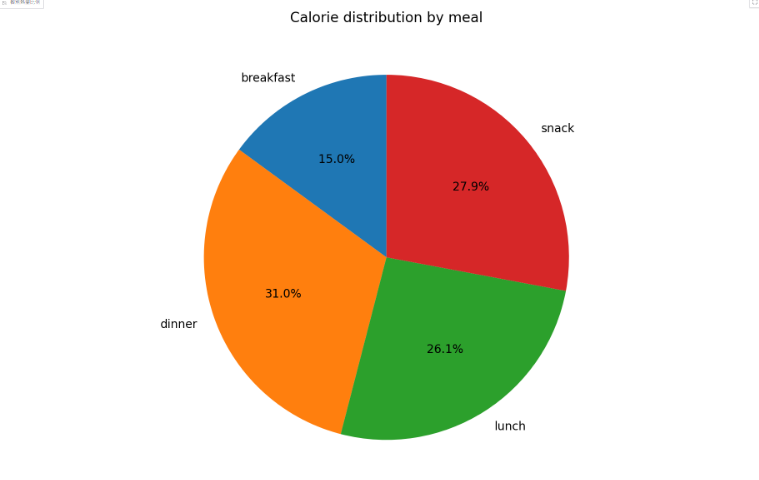